In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
import sys

sys.path.append('../../../DeLASE')
from delase import *

In [2]:
def lorenz(t, pt, rho=28, beta=8/3, sigma=10):
    x, y, z = pt[0], pt[1], pt[2]
    return np.array([sigma*(y - x), x*(rho - z) - y, x*y - beta*z])

In [3]:
x0 = np.random.randn(3)

In [4]:
t_span = [0, 200]
dt = 0.01
t_eval = np.arange(t_span[0], t_span[1], dt)
sol = solve_ivp(lambda t, x: lorenz(t, x), y0=x0, t_eval=t_eval, t_span=t_span)

In [5]:
signal = sol.y.T[2000:]

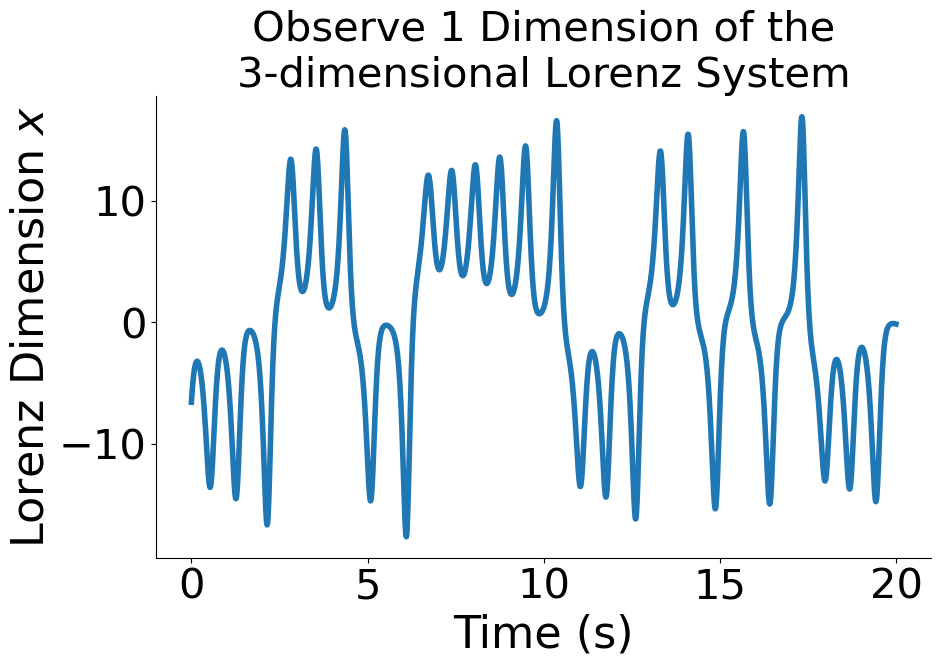

In [6]:
scale = 2
plt.figure(figsize=(5*scale, 3*scale))
plt.plot(np.arange(2000)*dt, signal[:2000, 0], linewidth=4)
ax = plt.gca()
ax.spines[['right', 'top']].set_visible(False)
ax.xaxis.set_ticks_position('bottom')
ax.tick_params(axis='y', which='both', left=True, right=False)
ax.set_xlabel('Time (s)', fontsize=16*scale)
ax.set_ylabel('Lorenz Dimension $x$', fontsize=16*scale)
ax.tick_params(labelsize=15*scale)
ax.set_title('Observe 1 Dimension of the\n3-dimensional Lorenz System', fontsize=15*scale)
plt.show()

In [7]:
delase = DeLASE(signal[:2000, [0]], p=5)

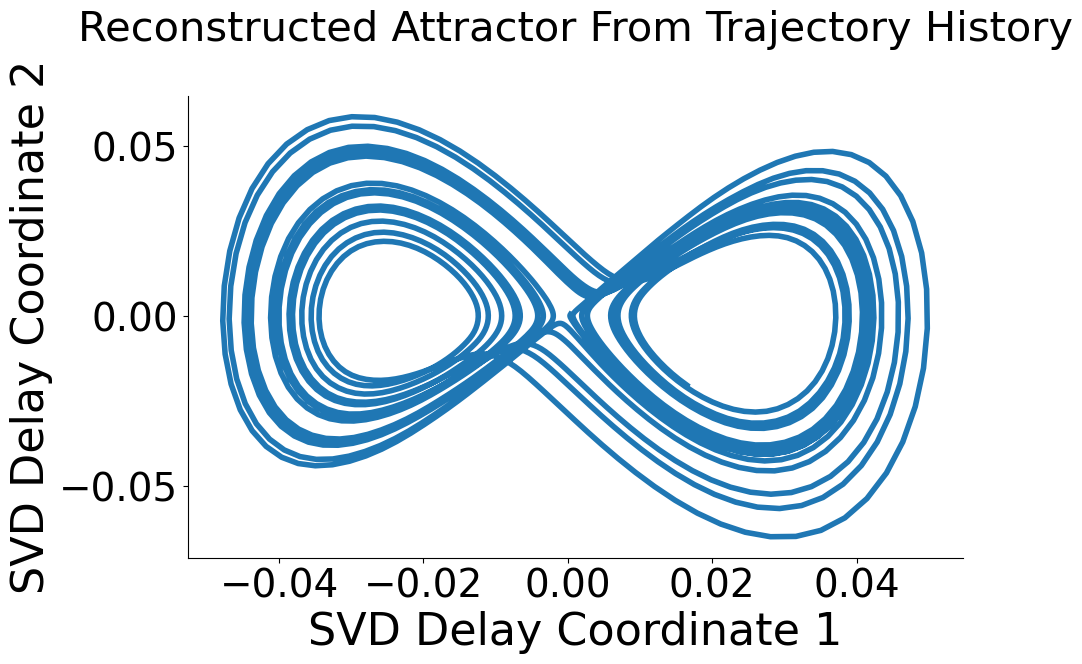

In [8]:
plt.figure(figsize=(5*scale, 3*scale))
plt.plot(delase.V[:, 0], delase.V[:, 1], linewidth=4)
ax = plt.gca()
ax.spines[['right', 'top']].set_visible(False)
ax.xaxis.set_ticks_position('bottom')
ax.tick_params(axis='y', which='both', left=True, right=False)
ax.set_xlabel('SVD Delay Coordinate 1', fontsize=16*scale)
ax.set_ylabel('SVD Delay Coordinate 2', fontsize=16*scale)
ax.tick_params(labelsize=14*scale)
ax.set_title('Reconstructed Attractor From Trajectory History\n', fontsize=15*scale)
plt.show()

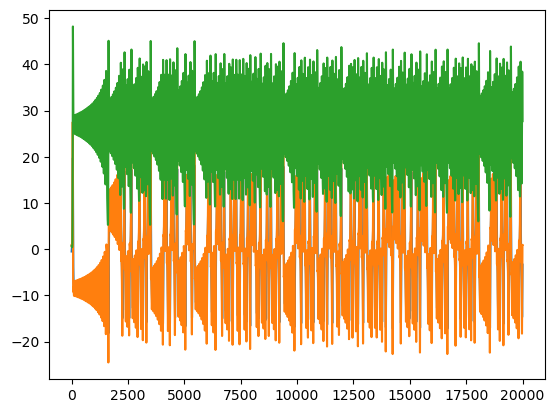

In [13]:
plt.plot(sol.y.T)

In [9]:
def vdp(x, t, mu):
    dx = np.zeros(2)
    dx[0] = x[1]
    dx[1] = mu*(1 - x[0]**2)*x[1] - x[0]
    return dx

In [23]:
t_span = [0, 200]
dt = 0.01
t_eval = np.arange(t_span[0], t_span[1], dt)
sol = solve_ivp(lambda t, x: vdp(x, t, mu=2), y0=np.random.randn(2), t_eval=t_eval, t_span=t_span)

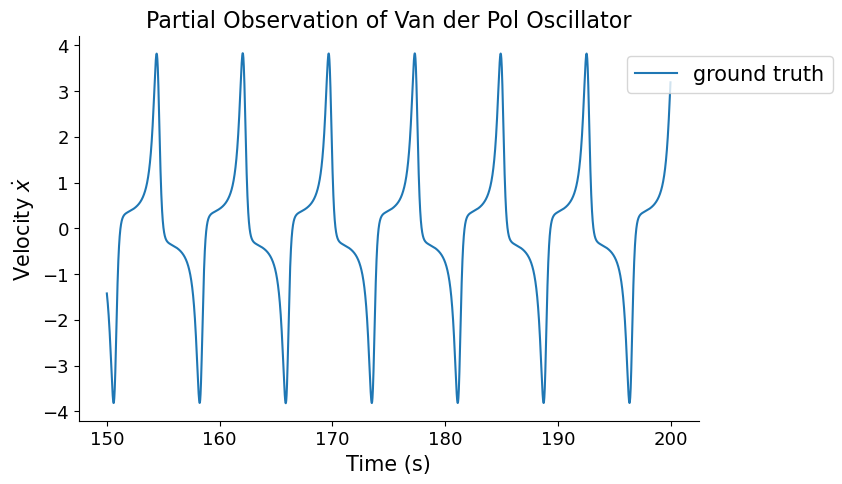

In [73]:
end_ind = 6000
plt.figure(figsize=(8, 5))
plt.plot(t_eval[15000:], sol.y.T[15000:, 1], c='C0', label='ground truth')
plt.xlabel('Time (s)', fontsize=15)
plt.ylabel('Velocity $\dot{x}$', fontsize=15)
plt.title('Partial Observation of Van der Pol Oscillator', fontsize=16)
plt.tick_params(labelsize=13)
ax = plt.gca()
ax.spines[['right', 'top']].set_visible(False)
ax.xaxis.set_ticks_position('bottom')
plt.legend(bbox_to_anchor=(1.05, 0.9), loc='center', ncol=1, fontsize=15)
plt.show()

In [60]:
delase = DeLASE(sol.y.T[:15000, [1]], p=500)

In [61]:
delase.compute_havok_dmd()

In [62]:
pred = delase.predict_havok_dmd(sol.y.T[15000:, [1]], reseed=sol.y.T[15000:, [1]].shape[0], tail_bite=True)

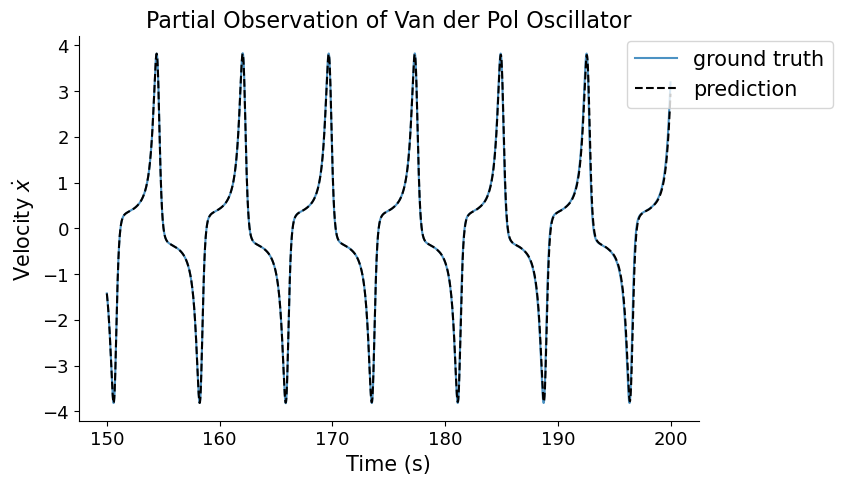

In [74]:
plt.figure(figsize=(8, 5))
plt.plot(t_eval[15000:], sol.y.T[15000:, 1], c='C0', label='ground truth', alpha=0.8)
plt.plot(t_eval[15000:], pred[:, 0], c='k', label='prediction', linestyle='--')
plt.plot()
plt.xlabel('Time (s)', fontsize=15)
plt.ylabel('Velocity $\dot{x}$', fontsize=15)
plt.title('Partial Observation of Van der Pol Oscillator', fontsize=16)
plt.tick_params(labelsize=13)
ax = plt.gca()
ax.spines[['right', 'top']].set_visible(False)
ax.xaxis.set_ticks_position('bottom')
plt.legend(bbox_to_anchor=(1.05, 0.9), loc='center', ncol=1, fontsize=15)
plt.show()

In [7]:
-20*2*np.pi

-125.66370614359172

In [310]:
lam1 = 0.5
lam2 = 20
freq1 = 60
freq2 = 2

A1 = np.array([[-lam1, -freq1*2*np.pi],
             [freq1*2*np.pi, -lam1]])

A2 = np.array([[-lam2, -freq2*2*np.pi],
             [freq2*2*np.pi, -lam2]])

In [336]:
def run_sde(A, x0, dt, T):
    n = A.shape[0]
    dW = np.sqrt(dt) * np.random.randn(T,n)
    x = np.zeros((T,n))
    x[0] = x0
    
    evals, evecs = np.linalg.eig(A)
    
    print(np.abs(evecs[:, 0]))

    # Simulate the stochastic differential equation
    for i in range(1, T):
        x[i] = x[i-1] + A@(x[i-1])*dt + (np.abs(evecs[:, 0])*1 * dW[i]) +(1 if i <= 2000 and i >= 1000 else 0)
    
    return x

In [337]:
dt = 0.001
time_span = 10 #s
x1 = run_sde(A2, np.random.randn(2)*1, dt, int(time_span/dt))
x2 = run_sde(A2, np.random.randn(2)*1, dt, int(time_span/dt))

[0.70710678 0.70710678]
[0.70710678 0.70710678]


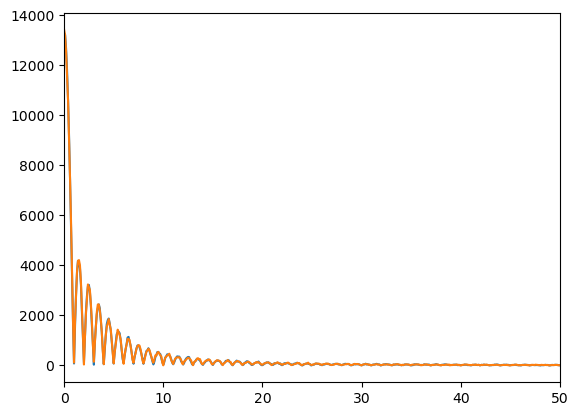

In [338]:
plt.plot(np.fft.rfftfreq(x1.shape[0], dt), (np.abs(np.fft.rfft(x1[:,0]))))
plt.plot(np.fft.rfftfreq(x2.shape[0], dt), (np.abs(np.fft.rfft(x2[:,0]))))
plt.xlim([0, 50])
plt.show()

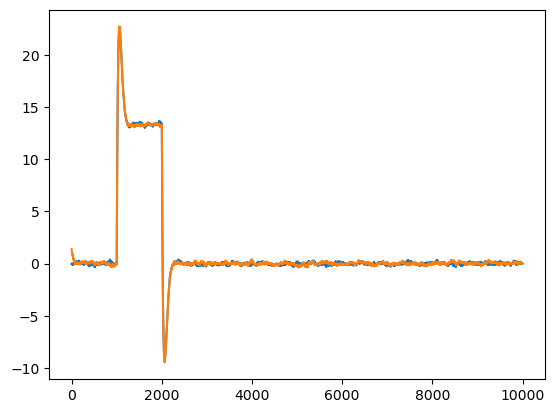

In [339]:
plt.plot(x1[:, 0])
plt.plot(x2[:, 0])

In [335]:
np.linalg.eigvals(A)

array([-1.+125.66370614j, -1.-125.66370614j])